In [15]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.utils.data import Dataset
from pyproj import CRS
import pandas as pd
import torch
import lightning as L
from torchvision import transforms
import xarray as xr
import torch
import torch.nn as nn
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from sklearn.model_selection import train_test_split
from lightning.pytorch import seed_everything
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import warnings
import os
warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('high')
seed_everything(42, workers=True)

Seed set to 42


42

## 

In [16]:
class SuperResolutionModel(L.LightningModule):
    def __init__(self, model, lr_mean, lr_std, hr_mean, hr_std):

        super().__init__()
        self.lr = 1e-3
        self.model = model
        self.psnr = PeakSignalNoiseRatio()
        self.ssim = StructuralSimilarityIndexMeasure()
        self.lr_mean = lr_mean
        self.lr_std = lr_std
        self.hr_mean = hr_mean
        self.hr_std = hr_std

    def forward(self, x):
        upscaled_img = self.model(x)
        return upscaled_img

    def training_step(self, batch, batch_idx):

        lr_img, hr_img = batch
        sr_img = self(lr_img)
        loss = nn.functional.mse_loss(sr_img, hr_img)
        psnr_value = self.psnr(sr_img, hr_img)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_psnr', psnr_value, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        lr_img, hr_img = batch
        sr_img = self(lr_img)
        loss = nn.functional.mse_loss(sr_img, hr_img)
        psnr_value = self.psnr(sr_img, hr_img)
        ssim_value = self.ssim(sr_img, hr_img)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_psnr', psnr_value, prog_bar=True)
        self.log('val_ssim', ssim_value, prog_bar=True)

        # Log images to TensorBoard every 10 steps
        # if batch_idx == 0 or batch_idx == 2:
        self.log_images(lr_img, hr_img, sr_img, self.current_epoch, batch_idx )

        return {'val_loss': loss, 'val_psnr': psnr_value, 'val_ssim': ssim_value}

    def test_step(self, batch, batch_idx):
        lr_img, hr_img = batch
        sr_img = self(lr_img)

        loss = nn.functional.mse_loss(sr_img, hr_img)
        psnr_value = self.psnr(sr_img, hr_img)
        ssim_value = self.ssim(sr_img, hr_img)

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_psnr', psnr_value, prog_bar=True)
        self.log('test_ssim', ssim_value, prog_bar=True)

        return {'test_loss': loss, 'test_psnr': psnr_value, 'test_ssim': ssim_value}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def log_images(self, lr_img, hr_img, sr_img, epoch, batch_idx):
        """
        Helper function to log input, target, and output images to TensorBoard, including cartopy plots
        """
        # Ensure images are in range [0, 1]
        lr_img = lr_img.cpu()
        hr_img = hr_img.cpu()
        sr_img = sr_img.cpu()

        lr_img = (lr_img * self.lr_std) + self.lr_mean
        hr_img = (hr_img * self.hr_std) + self.hr_mean

        # Convert lr_img, hr_img to numpy for cartopy visualization
        lr_img_np = lr_img.squeeze().numpy()[2]  # (lat, lon) format
        hr_img_np = hr_img.squeeze().numpy()[2]  # (lat, lon) format
        sr_img_np = sr_img.squeeze().numpy()[2]  # (lat, lon) format

        sr_img_np = (sr_img_np * self.hr_std) + self.hr_mean

        # Define color limits based on the range of values
        v_min = min(lr_img_np.min(), hr_img_np.min(), sr_img_np.min())
        v_max = max(lr_img_np.max(), hr_img_np.max(), sr_img_np.max())

        lon_min, lon_max = 5, 16.25
        lat_min, lat_max = 47, 58.22

        # Create a figure with three subplots for LR, HR, and SR images
        fig, ax = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.Mercator()})

        # Plot low-resolution data
        ax[0].coastlines()
        ax[0].add_feature(cf.BORDERS)
        ax[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        lr_plot = ax[0].imshow(lr_img_np, origin='upper', extent=[lon_min, lon_max, lat_min, lat_max],
                            transform=ccrs.PlateCarree(), cmap="YlOrRd", vmin=v_min, vmax=v_max)
        ax[0].set_title("Low-Resolution")

        # Plot high-resolution data
        ax[1].coastlines()
        ax[1].add_feature(cf.BORDERS)
        ax[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        hr_plot = ax[1].imshow(hr_img_np, origin='upper', extent=[lon_min, lon_max, lat_min, lat_max],
                            transform=ccrs.PlateCarree(), cmap="YlOrRd", vmin=v_min, vmax=v_max)
        ax[1].set_title("High-Resolution")

        # Plot super-resolved data
        ax[2].coastlines()
        ax[2].add_feature(cf.BORDERS)
        ax[2].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        sr_plot = ax[2].imshow(sr_img_np, origin='upper', extent=[lon_min, lon_max, lat_min, lat_max],
                            transform=ccrs.PlateCarree(), cmap="YlOrRd", vmin=v_min, vmax=v_max)
        ax[2].set_title("Super-Resolution Prediction")

        # Add a colorbar outside the last plot (super-resolution)
        cbar = fig.colorbar(sr_plot, ax=ax, location='right')
        cbar.set_label("Temperature (C)")  # Add units to the colorbar

        # Get the current logging directory (e.g., lightning_logs/version_0)
        log_dir = self.logger.log_dir
        save_dir = os.path.join(log_dir, 'val_prediction')
        os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

        # Save the figure to a PNG file
        plt.savefig(f"{save_dir}/batch_{str(batch_idx)}_epoch_{str(epoch)}.png", format='png', bbox_inches='tight')
        plt.close(fig)

In [17]:
%%capture cap
%run ./cacheb-authentication.py

Exception: Invalid username or password.

In [18]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

In [19]:
def compute_mean_std(data):
    """
    Computes the mean and standard deviation of the entire xarray dataset.
    Args:
        data (xarray.DataArray): Dataset (either HR or LR) to compute stats for
    Returns:
        mean (float), std (float): The mean and standard deviation of the dataset
    """
    mean = data.mean().values
    std = data.std().values
    return np.float64(mean), np.float64(std)

In [20]:
data = xr.open_dataset(
        "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr",
        engine="zarr",
        storage_options={"client_kwargs": {"trust_env": "true"}},
        chunks={},
    )
t2m_lr = data.t2m.astype("float32") - 273.15
t2m_lr.attrs["units"] = "C"
lr = t2m_lr.sel(**{"latitude": slice(47, 58.22), "longitude": slice(5, 16.25)})
lr = lr.sel(time="2024-10")
lr

<xarray.DataArray 't2m' (time: 744, latitude: 32, longitude: 32)> Size: 3MB
dask.array<getitem, shape=(744, 32, 32), dtype=float32, chunksize=(408, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 256B 47.03 47.38 47.73 ... 57.24 57.59 57.95
  * longitude  (longitude) float64 256B 5.273 5.625 5.977 ... 15.47 15.82 16.17
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 6kB 2024-10-01 ... 2024-10-31T23:00:00
Attributes:
    units:    C

In [21]:
data = xr.open_dataset(
        "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
        engine="zarr",
        storage_options={"client_kwargs": {"trust_env": "true"}},
        chunks={},
    )
t2m_hr = data.t2m.astype("float32") - 273.15
t2m_hr.attrs["units"] = "C"
hr = t2m_hr.sel(**{"latitude": slice(47, 58.22), "longitude": slice(5, 16.25)})
hr = hr.sel(time="2024-10")

In [22]:
hr = hr.load()
lr = lr.load()

Text(0.5, 1.0, 'High-Resolution')

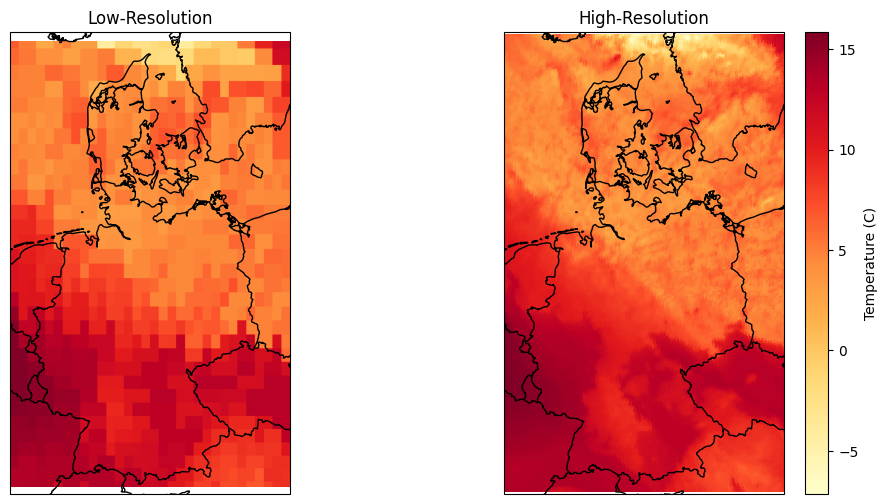

In [23]:
v_min = min(lr[0].values.min(), hr[0].min() )
v_max = max(lr[0].values.max(), hr[0].max() )

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.Mercator()})
# Define the area of interest
lon_min, lon_max = 5, 16.25
lat_min, lat_max = 47, 58.22
# Plot high-resolution data
ax[0].coastlines()
ax[0].add_feature(cf.BORDERS)
ax[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax[0].imshow(lr[0].values, origin='upper', extent=[lon_min, lon_max, lat_min, lat_max],
             transform=ccrs.PlateCarree(), cmap="YlOrRd",
             vmin=v_min, vmax = v_max)
ax[0].set_title("Low-Resolution")

# Plot low-resolution data
ax[1].coastlines()
ax[1].add_feature(cf.BORDERS)
ax[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
hr_fig = ax[1].imshow(hr[0].values,origin='upper', extent=[lon_min, lon_max, lat_min, lat_max],
             transform=ccrs.PlateCarree(), cmap="YlOrRd",
             vmin=v_min, vmax = v_max)

cbar_hr = fig.colorbar(hr_fig, ax=ax[1])
cbar_hr.set_label(f"Temperature ({hr.units})")  # Add units to the colorbar
ax[1].set_title("High-Resolution")

In [24]:
scale_factor_latitude = hr[0].shape[0] /lr[0].shape[0]
scale_factor_longitude = hr[0].shape[1] /lr[0].shape[1]
print(f"scaling factor latitude: {scale_factor_latitude}")
print(f"scaling factor longitude: {scale_factor_longitude}")

scaling factor latitude: 8.0
scaling factor longitude: 8.0


## Generate dataset

In [25]:
hr_mean, hr_std = compute_mean_std(hr)
lr_mean, lr_std = compute_mean_std(lr)
print(f"hr_mean: {hr_mean},hr_std {hr_std}")
print(f"lr_mean: {lr_mean},lr_std {lr_std}")

hr_mean: 10.094209671020508,hr_std 4.23423957824707
lr_mean: 10.007193565368652,lr_std 4.303609371185303


In [26]:
# Custom Dataset class
class CreateDataset(Dataset):
    def __init__(self, hr_data, lr_data, hr_mean, hr_std, lr_mean, lr_std):
        """
        Args:
            hr_data (xarray.DataArray): High-resolution data
            lr_data (xarray.DataArray): Low-resolution data
        """
        self.hr_data = hr_data
        self.lr_data = lr_data
        self.hr_mean, self.hr_std = hr_mean, hr_std
        self.lr_mean, self.lr_std = lr_mean, lr_std

        # Define the transformations for high-resolution and low-resolution data
        self.hr_transform = transforms.Normalize(mean=[hr_mean], std=[hr_std])
        self.lr_transform = transforms.Normalize(mean=[lr_mean], std=[lr_std])

    def __len__(self):
        # Dataset length is the number of time steps
        return self.hr_data.shape[0]

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to return
        Returns:
            tuple: (low-resolution, high-resolution) data as tensors
        """

        # Select the time slice at the given index
        hr_sample = self.hr_data.isel(time=idx).values  # (lat, lon)
        lr_sample = self.lr_data.isel(time=idx).values  # (lat, lon)

        # Convert to torch tensors and reshape to match (C, H, W) format
        hr_sample = torch.tensor(hr_sample, dtype=torch.float32).unsqueeze(0)
        lr_sample = torch.tensor(lr_sample, dtype=torch.float32).unsqueeze(0)

        hr_sample = self.hr_transform(hr_sample)
        lr_sample = self.lr_transform(lr_sample)

        return lr_sample, hr_sample

In [27]:
time_indices = np.arange(len(hr.time.values))

# First, split into train and remaining (validation + test)
train_indices, remaining_indices = train_test_split(time_indices , train_size=0.9, shuffle=True, random_state=42)

# Split the remaining indices into validation and test sets (50% of the remaining data each)
val_indices, test_indices = train_test_split(remaining_indices, test_size=0.1, shuffle=True, random_state=42)

# Use the indices to create train, validation, and test datasets
train_hr = hr.isel(time=train_indices)
val_hr = hr.isel(time=val_indices)
test_hr = hr.isel(time=test_indices)

# If you need to split both HR and LR datasets, do the same for lr:
train_lr = lr.isel(time=train_indices)
val_lr = lr.isel(time=val_indices)
test_lr = lr.isel(time=test_indices)

print(f"Train samples: {len(train_hr.time.values)}")
print(f"Validation samples: {len(val_hr.time.values)}")
print(f"Test samples: {len(test_hr.time.values)}")

Train samples: 669
Validation samples: 67
Test samples: 8


In [13]:
train_dataset = CreateDataset(hr_data=train_hr, lr_data=train_lr,
                              hr_mean=hr_mean, hr_std=hr_std,
                              lr_mean=lr_mean, lr_std=lr_std)

val_dataset = CreateDataset(hr_data=val_hr, lr_data=val_lr,
                             hr_mean=hr_mean, hr_std=hr_std,
                              lr_mean=lr_mean, lr_std=lr_std)

test_dataset = CreateDataset(hr_data=test_hr, lr_data=test_lr,
                              hr_mean=hr_mean, hr_std=hr_std,
                              lr_mean=lr_mean, lr_std=lr_std)

# DataLoader for batching and shuffling
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint
from model import SRResNet

sr_model = SRResNet(large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=8)

# Instantiate the LightningModule (SuperResolutionModel)
model = SuperResolutionModel(sr_model, lr_mean=lr_mean, lr_std=lr_std,
                             hr_mean=hr_mean, hr_std=hr_std)

# Define the model checkpoint callback
checkpoint_val_ssim = ModelCheckpoint(
    monitor="val_ssim",         # Metric to monitor (e.g., 'val_loss')
    filename="best-val-ssim-{epoch:02d}-{val_ssim:.2f}",  # Filename template
    save_top_k=1,               # Save only the best model (by val_loss)
    mode="max"                  # 'min' because we want to minimize validation loss
)
# Set up the Trainer with the checkpoint callback
trainer = L.Trainer(
    devices=[0],  # specify GPU devices
    max_epochs=100,
    accelerator="gpu",
    deterministic=True,
    callbacks=[checkpoint_val_ssim],
)

In [ ]:
# Start training
trainer.fit(model, train_loader, val_loader)

In [ ]:
trainer.test(model, test_loader)

In [28]:
import torch

def save_best_model_as_pt(checkpoint_callback, model_instance):
    """
    Saves the best checkpoint as a standard PyTorch .pth file without using Lightning.

    Args:
        checkpoint_callback (ModelCheckpoint): The checkpoint callback used during training.
        model_instance (nn.Module): The PyTorch model instance (the architecture you want to load).
    """
    # Get the path to the best checkpoint (file path)
    best_checkpoint_path = checkpoint_callback.best_model_path
    print(f"Best checkpoint path: {best_checkpoint_path}")

    # Load the checkpoint file (using PyTorch directly)
    checkpoint = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))  # Adjust map_location for GPU if necessary

    # Extract the model's state_dict from the checkpoint
    model_state_dict = checkpoint['state_dict']

    # You might need to adjust key names if they contain "module." or "model."
    model_instance.load_state_dict({k.replace("model.", ""): v for k, v in model_state_dict.items()})

    # Save the PyTorch model's state_dict as .pth
    pth_file_path = best_checkpoint_path.replace("ckpt", "pt")
    torch.save(model_instance.state_dict(), pth_file_path)

    print(f"Best model saved as: {pth_file_path}")

In [ ]:
save_best_model_as_pt(checkpoint_val_ssim, sr_model)

In [ ]:
from utils import create_gif_from_images
create_gif_from_images(trainer=trainer)

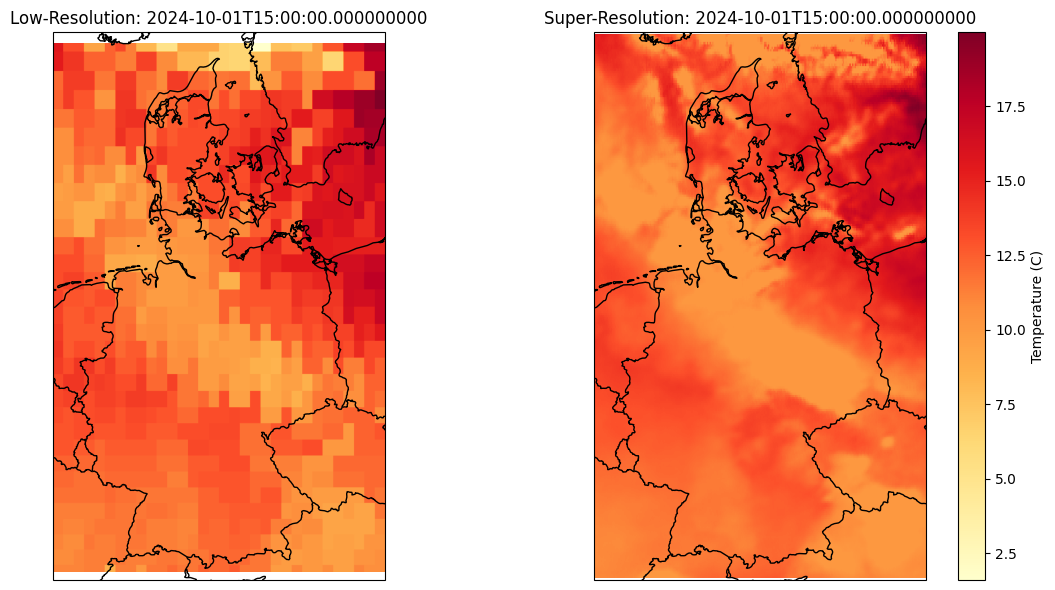

In [43]:
from model import SRResNet
from super_resolution_inference import SuperResolutionInference

model_path = "/home/ubuntu/project/DestinE_eXchange_SR/lightning_logs/version_46/checkpoints/best-val-ssim-epoch=97-val_ssim=0.59.pt"
model = SRResNet(large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=8)

# Initialize the inference class
sr = SuperResolutionInference(model_path=model_path, model_class=model)

# Load and preprocess a single LR image
lr_image = lr.sel(time="2024-10-01T15:00:00")
preprocessed_image = sr.preprocess(lr_image, lr_mean=lr_mean, lr_std=lr_std)

# Perform inference
sr_result = sr.inference(preprocessed_image)

# Post-process the SR result
sr_result = sr.postprocessing(sr_result, hr_mean, hr_std)
# Visualize the LR and SR images
fig = sr.visualize(lr_image=lr_image, sr_image=sr_result, lr_time=lr_image.time.values)

In [44]:
latitudes = np.linspace(lr_image.latitude.min(), lr_image.latitude.max(), int(lr_image.shape[0]*scale_factor_latitude))
longitudes = np.linspace(lr_image.longitude.min(), lr_image.longitude.max(), int(lr_image.shape[0]*scale_factor_latitude))

In [45]:
latitudes = np.linspace(lr_image.latitude.min(), lr_image.latitude.max(), int(lr_image.shape[0]*scale_factor_latitude))
longitudes = np.linspace(lr_image.longitude.min(), lr_image.longitude.max(), int(lr_image.shape[0]*scale_factor_latitude))
ds = xr.Dataset(
    data_vars={"t2m": (["latitude", "longitude"], sr_result)},  # Define the data variable
    coords={"latitude": latitudes, "longitude": longitudes, "time": lr_image.time},  # Assign the coordinates
    attrs={"description": "2-meter temperature"}
)
var = ds['t2m']
var = var.rename({'latitude': 'y', 'longitude': 'x'})
var.rio.write_crs("EPSG:4326", inplace=True)
# If data contains NaN, replace it with -9999 to make them transparent afterwards
var_filled = var.fillna(-9999)
var_filled.rio.to_raster('tif_filename.tif')

Color mapping saved to color_mapping.txt.


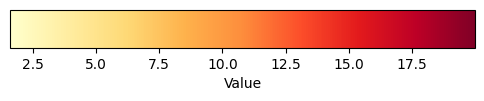

In [46]:
from utils import ColorMappingGenerator
# Create the color mapping generator
color_mapping_gen = ColorMappingGenerator(lr_image=lr_image, sr_result=sr_result, num_colors=20)
# Write the RGB mapping to a text file
color_mapping_gen.write_rgb_mapping_to_file("color_mapping.txt")
# Visualize the colorbar
color_mapping_gen.visualize_colorbar()

In [47]:
!gdal_translate -of VRT tif_filename.tif vrt_filename.vrt
!gdaldem color-relief  vrt_filename.vrt color_mapping.txt  output_vrt_filename.vrt
!gdal_translate -of COG output_vrt_filename.vrt dte_pred_cog_optimised_filename.tif
# !rio cogeo create  output_cog_filename.tif dte_pred_cog_optimised_filename.tif --overview-resampling average --overview-level 8 --web-optimized

Input file size is 256, 256
Input file size is 256, 256
0...10...20...30...40...50...60...70...80...90...100 - done.


In [48]:
ds = xr.Dataset(
    data_vars={"t2m": (["latitude", "longitude"], lr_image.values)},  # Define the data variable
    coords={"latitude": lr_image.latitude, "longitude": lr_image.longitude, "time": lr_image.time},  # Assign the coordinates
    attrs={"description": "2-meter temperature"}
)
var = ds['t2m']
var = var.rename({'latitude': 'y', 'longitude': 'x'})
var.rio.write_crs("EPSG:4326", inplace=True)
var_filled = var.fillna(-9999)
var_filled.rio.to_raster('tif_filename.tif')

In [49]:
!gdal_translate -of VRT tif_filename.tif vrt_filename.vrt
!gdaldem color-relief  vrt_filename.vrt color_mapping.txt  output_vrt_filename.vrt
!gdal_translate -of COG output_vrt_filename.vrt dte_lr_cog_optimised_filename.tif
# !rio cogeo create  output_cog_filename.tif dte_lr_cog_optimised_filename.tif --overview-resampling average --web-optimized

Input file size is 32, 32
Input file size is 32, 32
0...10...20...30...40...50...60...70...80...90...100 - done.
